In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zahidmughal2343/global-cancer-patients-2015-2024")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import trange
import torch.nn as nn
import torch.optim as optim
warnings.filterwarnings('ignore')
sns.set()

In [3]:
df = pd.read_csv('/kaggle/input/global_cancer_patients_2015_2024.csv')
df.head()

,Patient_ID,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
0,PT0000000,71,Male,UK,2021,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,62913.44,5.9,4.92
1,PT0000001,34,Male,China,2021,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,12573.41,4.7,4.65
2,PT0000002,80,Male,Pakistan,2023,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,6984.33,7.1,5.84
3,PT0000003,40,Male,UK,2015,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,67446.25,1.6,3.12
4,PT0000004,43,Female,Brazil,2017,5.1,2.8,2.3,6.7,0.5,Skin,Stage III,77977.12,2.9,3.62


In [4]:
df.shape

(50000, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Patient_ID             50000 non-null  object 
 1   Age                    50000 non-null  int64  
 2   Gender                 50000 non-null  object 
 3   Country_Region         50000 non-null  object 
 4   Year                   50000 non-null  int64  
 5   Genetic_Risk           50000 non-null  float64
 6   Air_Pollution          50000 non-null  float64
 7   Alcohol_Use            50000 non-null  float64
 8   Smoking                50000 non-null  float64
 9   Obesity_Level          50000 non-null  float64
 10  Cancer_Type            50000 non-null  object 
 11  Cancer_Stage           50000 non-null  object 
 12  Treatment_Cost_USD     50000 non-null  float64
 13  Survival_Years         50000 non-null  float64
 14  Target_Severity_Score  50000 non-null  float64
dtypes:

In [6]:
df.isnull().sum()

Patient_ID               0
Age                      0
Gender                   0
Country_Region           0
Year                     0
Genetic_Risk             0
Air_Pollution            0
Alcohol_Use              0
Smoking                  0
Obesity_Level            0
Cancer_Type              0
Cancer_Stage             0
Treatment_Cost_USD       0
Survival_Years           0
Target_Severity_Score    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.drop(columns = ['Patient_ID'], axis = 1, inplace = True)

In [9]:
df.head()

,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
0,71,Male,UK,2021,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,62913.44,5.9,4.92
1,34,Male,China,2021,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,12573.41,4.7,4.65
2,80,Male,Pakistan,2023,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,6984.33,7.1,5.84
3,40,Male,UK,2015,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,67446.25,1.6,3.12
4,43,Female,Brazil,2017,5.1,2.8,2.3,6.7,0.5,Skin,Stage III,77977.12,2.9,3.62


In [10]:
df.describe()

,Age,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,54.421540,2019.480520,5.001698,5.010126,5.010880,4.989826,4.991176,52467.298239,5.006462,4.951207
std,20.224451,2.871485,2.885773,2.888399,2.888769,2.881579,2.894504,27363.229379,2.883335,1.199677
min,20.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5000.050000,0.000000,0.900000
25%,37.000000,2017.000000,2.500000,2.500000,2.500000,2.500000,2.500000,28686.225000,2.500000,4.120000
50%,54.000000,2019.000000,5.000000,5.000000,5.000000,5.000000,5.000000,52474.310000,5.000000,4.950000
75%,72.000000,2022.000000,7.500000,7.500000,7.500000,7.500000,7.500000,76232.720000,7.500000,5.780000
max,89.000000,2024.000000,10.000000,10.000000,10.000000,10.000000,10.000000,99999.840000,10.000000,9.160000


In [11]:
df.columns

Index(['Age', 'Gender', 'Country_Region', 'Year', 'Genetic_Risk',
       'Air_Pollution', 'Alcohol_Use', 'Smoking', 'Obesity_Level',
       'Cancer_Type', 'Cancer_Stage', 'Treatment_Cost_USD', 'Survival_Years',
       'Target_Severity_Score'],
      dtype='object')

In [12]:
cat_cols, num_cols = [], []
for column in df.columns:
    if df[column].dtype == 'object' or df[column].nunique() < 20:
        cat_cols.append(column)
    else:
        num_cols.append(column)

In [13]:
print(f'*** Number of categorical columns: {len(cat_cols)}')
print(f'*** Categorical columns: {cat_cols}')
print(f'+++ Number of numerical columns: {len(num_cols)}')
print(f'+++ Numerical columns: {num_cols})')

*** Number of categorical columns: 5
*** Categorical columns: ['Gender', 'Country_Region', 'Year', 'Cancer_Type', 'Cancer_Stage']
+++ Number of numerical columns: 9
+++ Numerical columns: ['Age', 'Genetic_Risk', 'Air_Pollution', 'Alcohol_Use', 'Smoking', 'Obesity_Level', 'Treatment_Cost_USD', 'Survival_Years', 'Target_Severity_Score'])


Gender Column
Number of unique values: 3
Unique values are: ['Male' 'Female' 'Other']
Value counts of unique values:
 Gender
Male      16796
Female    16709
Other     16495
Name: count, dtype: int64


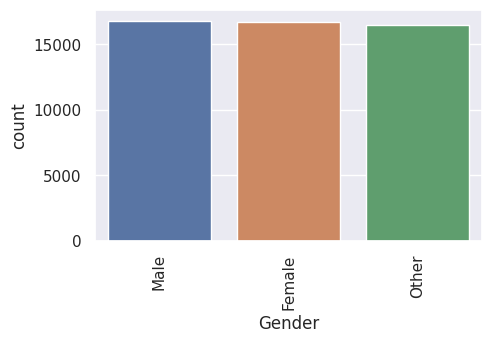

Country_Region Column
Number of unique values: 10
Unique values are: ['UK' 'China' 'Pakistan' 'Brazil' 'Germany' 'Canada' 'USA' 'India'
 'Australia' 'Russia']
Value counts of unique values:
 Country_Region
Australia    5092
UK           5060
USA          5060
India        5040
Germany      5024
Russia       5017
Brazil       5004
Pakistan     4926
China        4913
Canada       4864
Name: count, dtype: int64


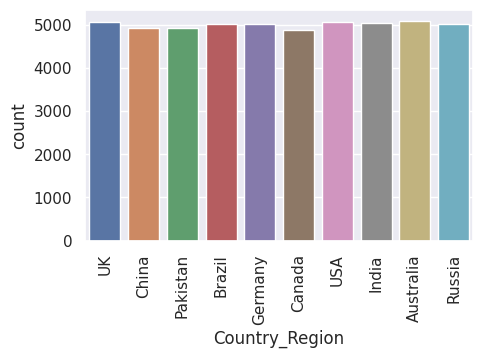

Year Column
Number of unique values: 10
Unique values are: [2021 2023 2015 2017 2018 2022 2016 2024 2020 2019]
Value counts of unique values:
 Year
2016    5094
2020    5079
2019    5065
2017    5037
2015    5012
2024    4994
2021    4967
2018    4936
2023    4935
2022    4881
Name: count, dtype: int64


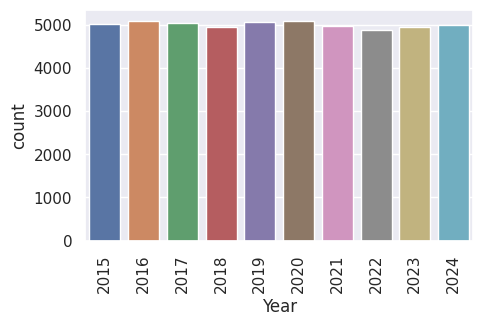

Cancer_Type Column
Number of unique values: 8
Unique values are: ['Lung' 'Leukemia' 'Breast' 'Colon' 'Skin' 'Cervical' 'Prostate' 'Liver']
Value counts of unique values:
 Cancer_Type
Colon       6376
Prostate    6308
Leukemia    6266
Liver       6249
Skin        6231
Cervical    6222
Breast      6189
Lung        6159
Name: count, dtype: int64


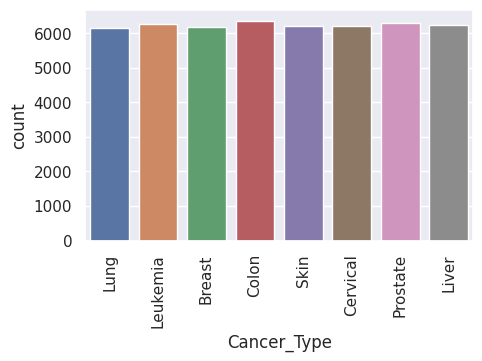

Cancer_Stage Column
Number of unique values: 5
Unique values are: ['Stage III' 'Stage 0' 'Stage II' 'Stage I' 'Stage IV']
Value counts of unique values:
 Cancer_Stage
Stage II     10124
Stage I      10046
Stage III    10008
Stage IV      9933
Stage 0       9889
Name: count, dtype: int64


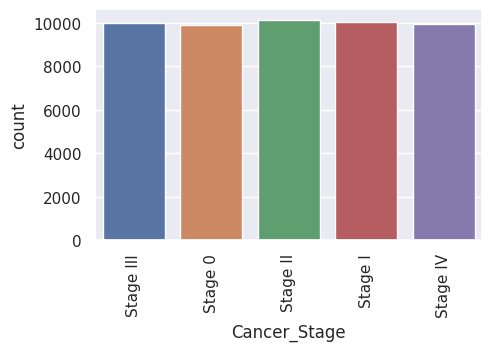

In [14]:
for column in cat_cols:
    print(f'{column} Column')
    print(f'Number of unique values: {df[column].nunique()}')
    print(f'Unique values are: {df[column].unique()}')
    print(f'Value counts of unique values:\n {df[column].value_counts()}')
    plt.figure(figsize = (5, 3))
    sns.countplot(data = df, x = column)
    plt.xticks(rotation = 90)
    plt.show()
    print('==============================================================')

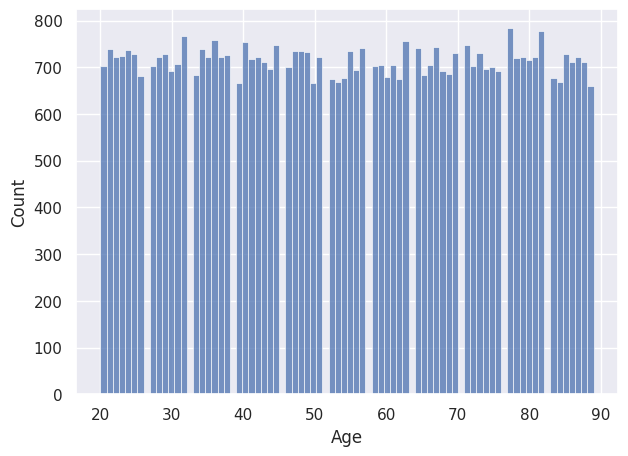

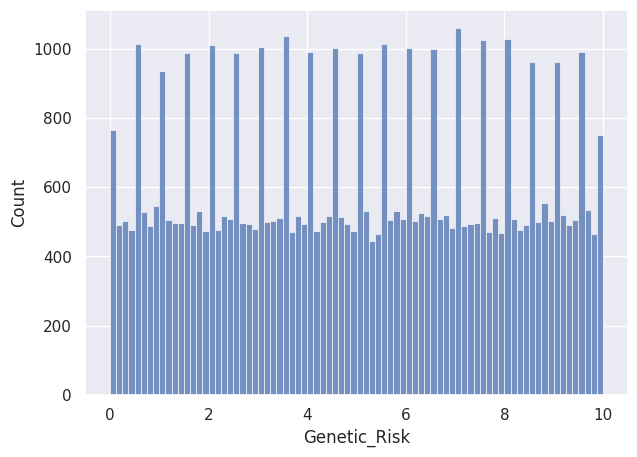

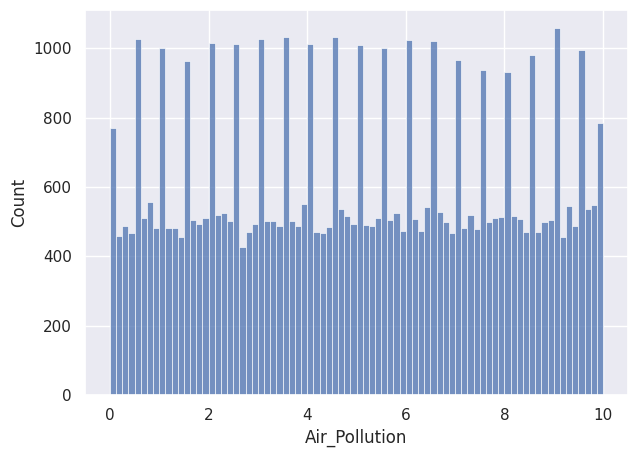

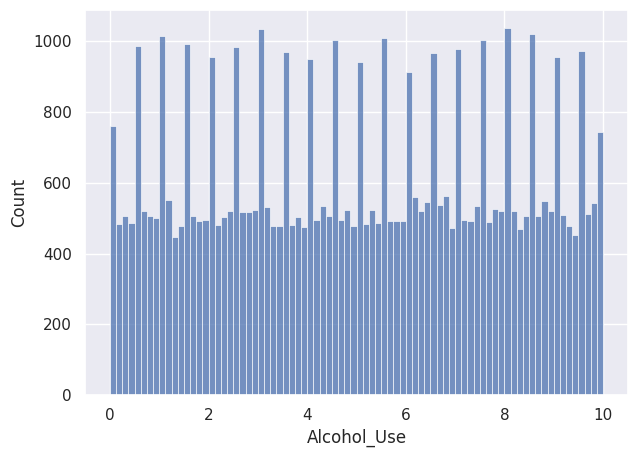

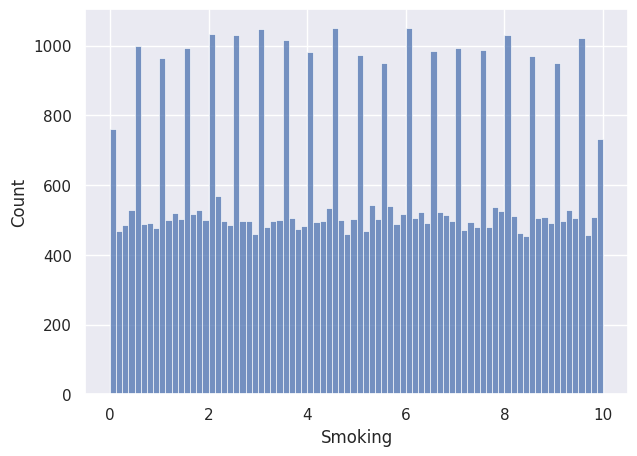

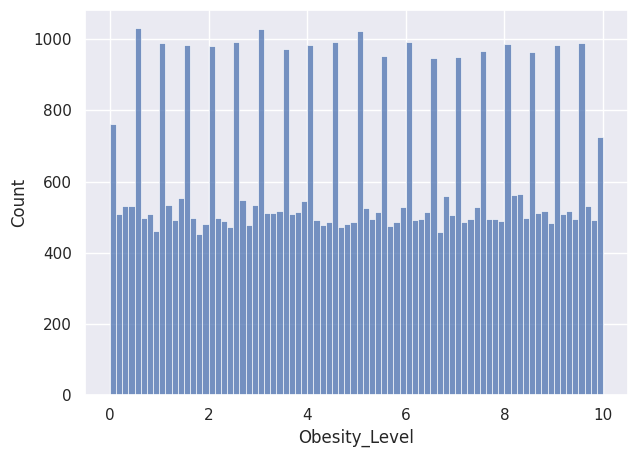

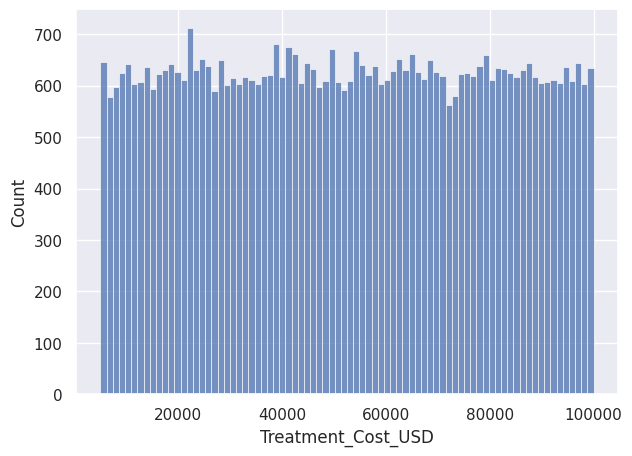

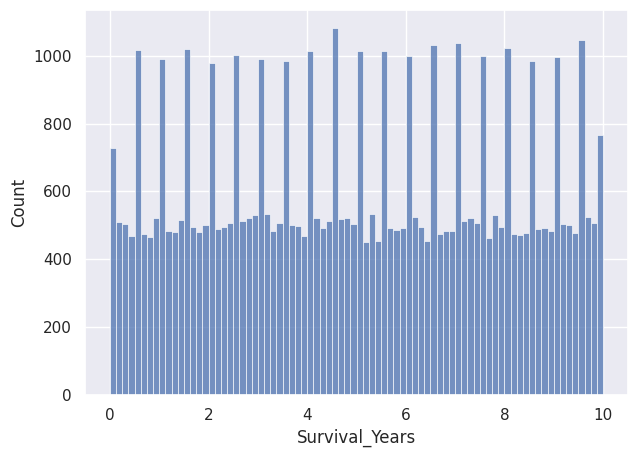

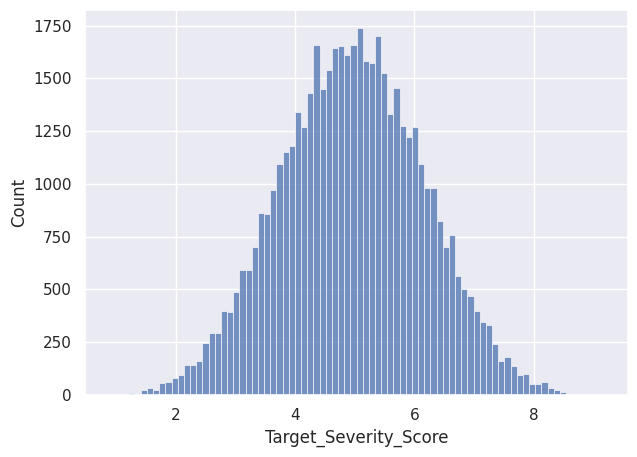

In [15]:
for column in num_cols:
    plt.figure(figsize = (7, 5))
    sns.histplot(data = df, x = column, bins = 80)
    plt.show()

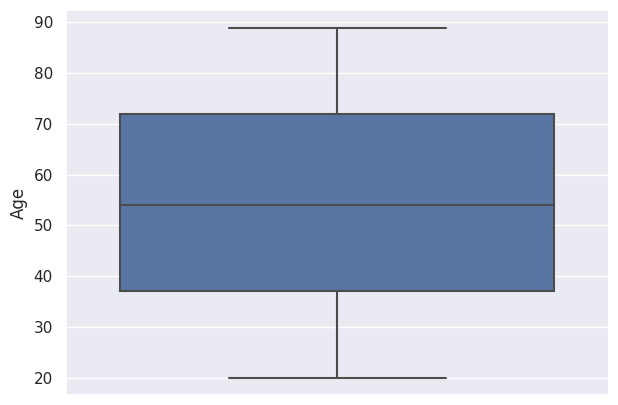

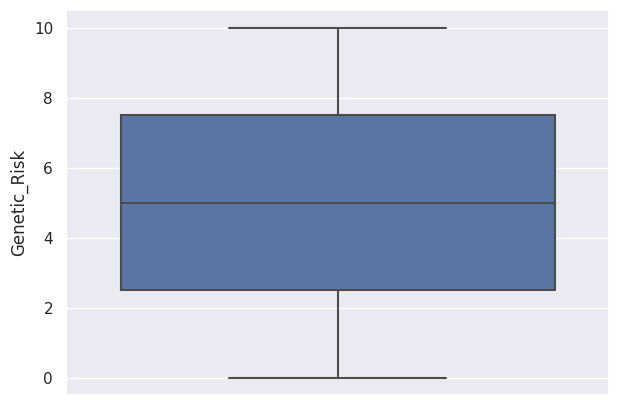

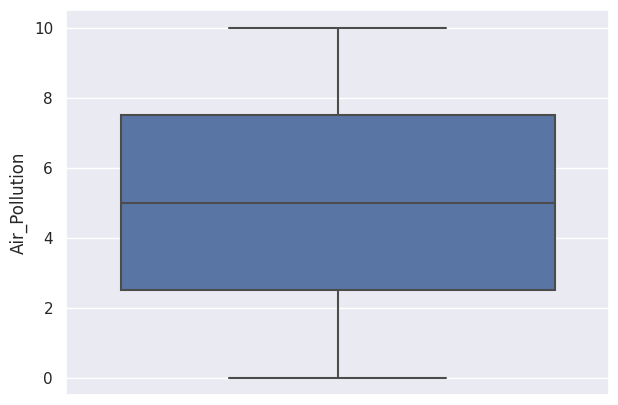

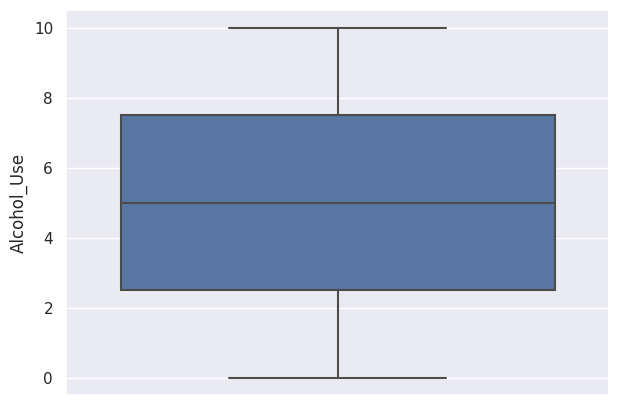

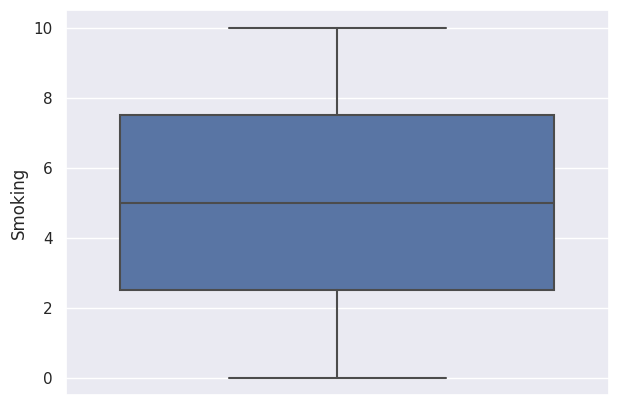

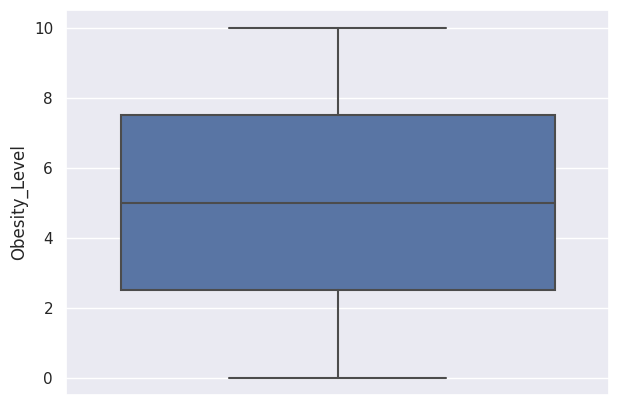

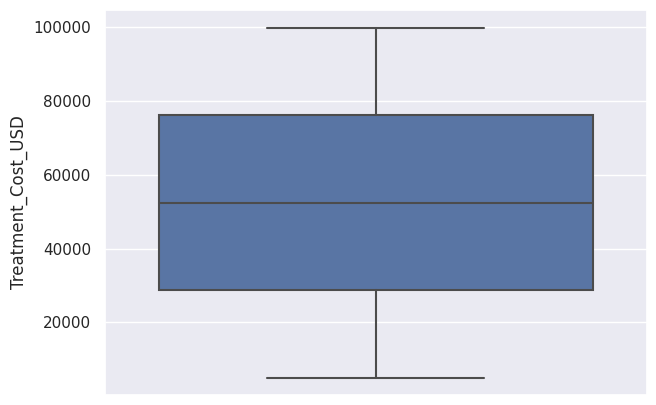

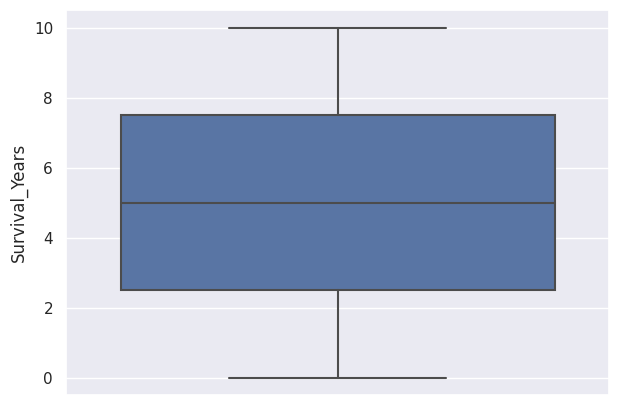

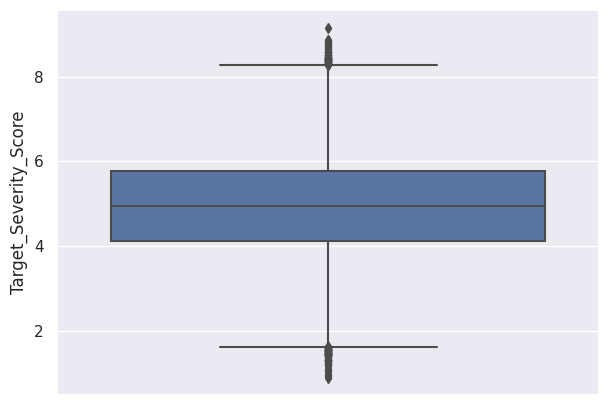

In [16]:
for column in num_cols:
    plt.figure(figsize = (7, 5))
    sns.boxplot(data = df, y = column)
    plt.show()

In [17]:
df[df['Target_Severity_Score'] > 8.2].shape

(104, 14)

In [18]:
df = df[df['Target_Severity_Score'] < 8.2]

In [19]:
df[df['Target_Severity_Score'] < 1.8].shape

(146, 14)

In [20]:
df = df[df['Target_Severity_Score'] > 1.8]

In [21]:
df.shape

(49737, 14)

In [22]:
ct = ColumnTransformer(transformers = [
    ('encoder', OneHotEncoder(drop = 'first', handle_unknown = 'ignore'), cat_cols)
], remainder = 'passthrough')

In [23]:
X = df.drop(columns = ['Target_Severity_Score'], axis = 1)
y = df['Target_Severity_Score']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 101, shuffle = True)

In [25]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size = 0.5, random_state = 101, shuffle = True)

In [26]:
print(f'Train set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')
print(f'Validation set size: {len(X_valid)}')

Train set size: 29842
Test set size: 9947
Validation set size: 9948


In [27]:
X_train_tr = ct.fit_transform(X_train)

In [28]:
X_test_tr = ct.transform(X_test)

In [29]:
X_valid_tr = ct.transform(X_valid)

In [30]:
scaler = StandardScaler()

In [31]:
X_train_scaled = scaler.fit_transform(X_train_tr)

In [32]:
X_test_scaled = scaler.transform(X_test_tr)

In [33]:
X_valid_scaled = scaler.transform(X_valid_tr)

In [34]:
X_train_scaled.shape

(29842, 39)

In [35]:
class MyDataset(Dataset):
    def __init__(self, X, Y = None, transform = None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            x = self.transform(x)
        if self.Y is not None:
            y = self.Y[idx]
            return x, y
        return x

In [36]:
train_dataset = MyDataset(X_train_scaled)
test_dataset = MyDataset(X_test_scaled)
valid_dataset = MyDataset(X_valid_scaled)

In [37]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)
valid_loader = DataLoader(valid_dataset, batch_size = 64, shuffle = False)

In [38]:
device = ('cuda' if torch.cuda.is_available()
         else 'mps' if torch.backends.mps.is_available()
         else 'cpu')

In [39]:
print(f'Using {device} device')

Using cuda device


In [40]:
def plot_results(train_losses, valid_losses):
    plt.figure(figsize = (7, 5))
    plt.plot(train_losses, label = 'Train', color = 'teal')
    plt.plot(valid_losses, label = 'Validation', color = 'orange')
    plt.title('Training loss vs Validation loss', fontsize = 15)
    plt.xlabel('Epoch', fontsize = 10)
    plt.ylabel('Loss (mse)', fontsize = 10)
    plt.legend()
    plt.show()

In [41]:
def train_step(model, criterion, optimizer, dataloader, device = device):
    running_loss = 0.0
    model.train()
    for x in dataloader:
        x = x.to(device).float()
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, x)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

In [42]:
def valid_step(model, criterion, dataloader, device = device):
    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for x in dataloader:
            x = x.to(device).float()
            pred = model(x)
            running_loss += criterion(pred, x).item()
    return running_loss / len(dataloader)

In [43]:
def train_model(model, n_epochs, optimizer, train_loader, valid_loader, device = device):
    train_losses, valid_losses = [], []
    criterion = nn.MSELoss()
    for epoch in (pbar := trange(n_epochs)):
        train_loss = train_step(model, criterion, optimizer, train_loader, device)
        valid_loss = valid_step(model, criterion, valid_loader, device)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        pbar.set_description(f'Train Loss: {train_loss:.3f} | Validation Loss: {valid_loss:.3f}')
    plot_results(train_losses, valid_losses)
    return {'train_loss': train_loss, 'valid_loss': valid_loss}

In [44]:
class autoencoder(nn.Module):
    def __init__(self, input_size):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Train Loss: 0.842 | Validation Loss: 0.842: 100%|██████████| 30/30 [00:35<00:00,  1.17s/it]


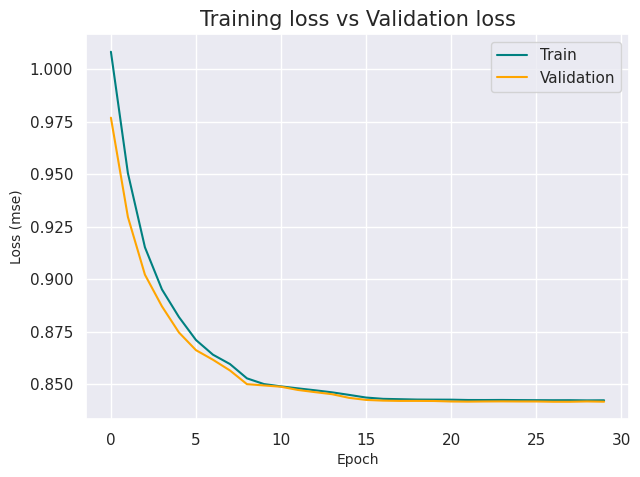

In [45]:
model = autoencoder(input_size = 39).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 30, optimizer, train_loader, valid_loader)

In [46]:
criterion = nn.MSELoss()

In [47]:
test_loss = valid_step(model, criterion, test_loader, device = device)

In [48]:
print(f'Test loss: {test_loss:.3f}')

Test loss: 0.841


In [49]:
model.eval()
with torch.no_grad():
    features = []
    for x in train_loader:
        x = x.to(device).float()
        encoded = model.encoder(x)
        features.append(encoded.cpu())
    features = torch.cat(features, dim = 0)

In [50]:
features[0]

tensor([ 3.7000, 12.0725,  9.9964, 16.5653,  4.8613,  3.9311,  6.5307, 12.4696,
         0.0000,  0.0000])

In [51]:
features

tensor([[ 3.7000, 12.0725,  9.9964,  ..., 12.4696,  0.0000,  0.0000],
        [ 5.4883, 10.9900, 12.3841,  ...,  6.9123,  0.0000,  0.0000],
        [14.5921,  7.9750, 17.2992,  ..., 11.6607,  0.0000,  0.0000],
        ...,
        [ 5.0839, 15.6967, 11.3130,  ..., 10.3743,  0.0000,  0.0000],
        [ 8.1528,  7.8958,  5.2855,  ...,  5.0977,  0.0000,  0.0000],
        [ 5.3456, 22.1617, 16.7756,  ..., 15.6845,  0.0000,  0.0000]])

In [52]:
train_feature = features

In [53]:
model.eval()
with torch.no_grad():
    test_features = []
    for x in test_loader:
        x = x.to(device).float()
        encoded = model.encoder(x)
        test_features.append(encoded.cpu())
    test_features = torch.cat(test_features, dim = 0)

In [54]:
model.eval()
with torch.no_grad():
    valid_features = []
    for x in valid_loader:
        x = x.to(device).float()
        encoded = model.encoder(x)
        valid_features.append(encoded.cpu())
    valid_features = torch.cat(valid_features, dim = 0)

In [55]:
train = pd.DataFrame(data = train_feature, columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [56]:
train.head()

,0,1,2,3,4,5,6,7,8,9
0,3.699975,12.072520,9.996381,16.565269,4.861270,3.931114,6.530692,12.469593,0.0,0.0
1,5.488273,10.989974,12.384112,7.392910,11.903388,24.258509,9.224616,6.912293,0.0,0.0
2,14.592093,7.974998,17.299231,12.743115,8.244636,25.107033,7.391789,11.660735,0.0,0.0
3,8.558600,11.769935,8.955419,14.693330,9.656647,21.113558,14.815263,15.978930,0.0,0.0
4,5.583104,20.224871,13.586147,16.230124,8.208619,28.009401,15.253068,20.165430,0.0,0.0


In [57]:
test = pd.DataFrame(data = test_features, columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
test.head()

,0,1,2,3,4,5,6,7,8,9
0,3.745383,8.911106,8.692589,13.210746,6.999807,18.980276,9.381606,16.097588,0.0,0.0
1,12.202298,9.657603,13.561066,16.123455,12.855567,12.394272,13.244634,10.545498,0.0,0.0
2,5.070462,18.451220,10.389449,5.472446,8.428210,20.663189,4.765624,3.151585,0.0,0.0
3,5.080027,12.599383,18.636097,9.401504,7.723475,19.012049,12.857763,9.785913,0.0,0.0
4,7.579425,12.151426,9.142628,12.582362,7.040269,20.538446,15.947289,8.507730,0.0,0.0


In [58]:
valid = pd.DataFrame(data = valid_features, columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
valid.head()

,0,1,2,3,4,5,6,7,8,9
0,10.304222,10.876155,12.447373,6.944241,3.032393,12.098540,11.998704,21.428583,0.0,0.0
1,8.366100,10.957175,11.768812,16.340784,6.607046,16.191790,10.206450,11.700540,0.0,0.0
2,9.342971,3.173579,13.430285,1.842011,8.064244,16.396509,12.250243,15.514954,0.0,0.0
3,3.608450,4.981647,6.191647,4.056207,10.206835,15.991879,11.196805,5.202205,0.0,0.0
4,2.227902,16.826099,17.911526,12.093347,11.570963,29.179789,12.966957,16.623446,0.0,0.0


In [59]:
train.shape

(29842, 10)

In [61]:
train[9].value_counts()

9
0.0    29842
Name: count, dtype: int64

In [62]:
train[8].value_counts()

8
0.0    29842
Name: count, dtype: int64

In [63]:
train.drop(columns = [8, 9], axis = 1, inplace = True)
test.drop(columns = [8, 9], axis = 1, inplace = True)
valid.drop(columns = [8, 9], axis = 1, inplace = True)

In [98]:
train = train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
test = test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
valid = valid.reset_index(drop = True)
y_valid = y_valid.reset_index(drop = True)

In [99]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
valid_scaled = scaler.transform(valid)

In [100]:
class MyDataset(Dataset):
    def __init__(self, X, Y = None, transform = None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            x = self.transform(x)
        if self.Y is not None:
            y = self.Y[idx]
            return x, y
        return x

In [101]:
train_dataset2 = MyDataset(train_scaled, y_train)
test_dataset2 = MyDataset(test_scaled, y_test)
valid_dataset2 = MyDataset(valid_scaled, y_valid)

In [102]:
train_loader2 = DataLoader(train_dataset2, batch_size = 64, shuffle = True)
test_loader2 = DataLoader(test_dataset2, batch_size = 64, shuffle = False)
valid_loader2 = DataLoader(valid_dataset2, batch_size = 64, shuffle = False)

In [103]:
def train_step(model, criterion, optimizer, dataloader, device = device):
    running_loss = 0.0
    model.train()
    for x, y in dataloader:
        optimizer.zero_grad()
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

In [104]:
def valid_step(model, criterion, dataloader, device = device):
    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device).float(), y.to(device).float()
            pred = model(x)
            running_loss += criterion(pred, y).item()
    return running_loss / len(dataloader)

In [105]:
class nn_model(nn.Module):
    def __init__(self, input_size):
        super(nn_model, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 1.387 | Validation Loss: 1.425: 100%|██████████| 30/30 [00:33<00:00,  1.11s/it]


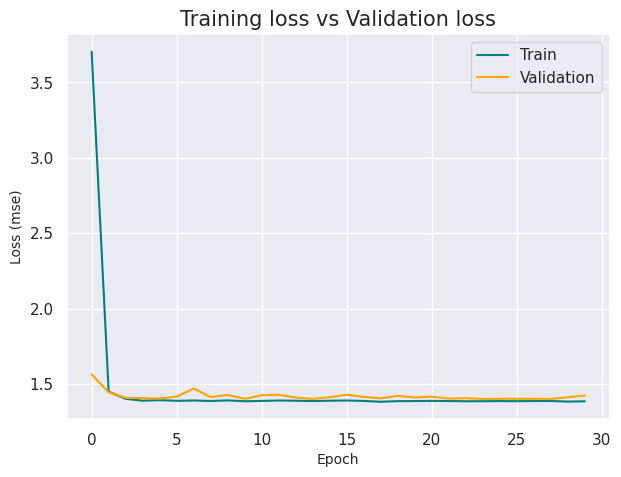

In [110]:
model = nn_model(input_size = 8).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 30, optimizer, train_loader2, valid_loader2)

In [107]:
y_train.mean()

4.947768916292474

In [111]:
X_train_scaled

array([[ 1.40692321, -0.70538367, -0.33102005, ..., -0.82857097,
        -1.19646036, -0.38175888],
       [-0.71077085, -0.70538367, -0.33102005, ..., -0.44677665,
         1.26368999,  0.20862599],
       [-0.71077085, -0.70538367,  3.02096509, ..., -1.07153099,
         0.86131823,  0.17389747],
       ...,
       [ 1.40692321, -0.70538367, -0.33102005, ..., -0.30794235,
        -0.67825617, -0.69431558],
       [-0.71077085,  1.41766821, -0.33102005, ..., -0.58561095,
         0.1428698 , -0.93741523],
       [-0.71077085, -0.70538367, -0.33102005, ..., -1.07153099,
        -0.4834282 , -0.06920218]])

In [114]:
train_feature

tensor([[ 3.7000, 12.0725,  9.9964,  ..., 12.4696,  0.0000,  0.0000],
        [ 5.4883, 10.9900, 12.3841,  ...,  6.9123,  0.0000,  0.0000],
        [14.5921,  7.9750, 17.2992,  ..., 11.6607,  0.0000,  0.0000],
        ...,
        [ 5.0839, 15.6967, 11.3130,  ..., 10.3743,  0.0000,  0.0000],
        [ 8.1528,  7.8958,  5.2855,  ...,  5.0977,  0.0000,  0.0000],
        [ 5.3456, 22.1617, 16.7756,  ..., 15.6845,  0.0000,  0.0000]])

In [139]:
def data_pre(data1, data2):
    df1 = pd.DataFrame(data = data1, columns = [f'orig{i}' for i in range(data1.shape[1])])
    df2 = pd.DataFrame(data = data2, columns = [f'new{i}' for i in range(data2.shape[1])])
    df_final = pd.concat([df1, df2], axis = 1)
    df_final.reset_index(drop = True, inplace = True)
    return df_final

In [140]:
train_df = data_pre(X_train_tr, train_feature)

In [141]:
train_df.head()

,orig0,orig1,orig2,orig3,orig4,orig5,orig6,orig7,orig8,orig9,...,new0,new1,new2,new3,new4,new5,new6,new7,new8,new9
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.699975,12.072520,9.996381,16.565269,4.861270,3.931114,6.530692,12.469593,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,5.488273,10.989974,12.384112,7.392910,11.903388,24.258509,9.224616,6.912293,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.592093,7.974998,17.299231,12.743115,8.244636,25.107033,7.391789,11.660735,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.558600,11.769935,8.955419,14.693330,9.656647,21.113558,14.815263,15.978930,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,5.583104,20.224871,13.586147,16.230124,8.208619,28.009401,15.253068,20.165430,0.0,0.0


In [142]:
test_df = data_pre(X_test_tr, test_features)
test_df.head()

,orig0,orig1,orig2,orig3,orig4,orig5,orig6,orig7,orig8,orig9,...,new0,new1,new2,new3,new4,new5,new6,new7,new8,new9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.745383,8.911106,8.692589,13.210746,6.999807,18.980276,9.381606,16.097588,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.202298,9.657603,13.561066,16.123455,12.855567,12.394272,13.244634,10.545498,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.070462,18.451220,10.389449,5.472446,8.428210,20.663189,4.765624,3.151585,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.080027,12.599383,18.636097,9.401504,7.723475,19.012049,12.857763,9.785913,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,7.579425,12.151426,9.142628,12.582362,7.040269,20.538446,15.947289,8.507730,0.0,0.0


In [143]:
valid_df = data_pre(X_valid_tr, valid_features)

In [144]:
train_df.drop(columns = ['new8', 'new9'], axis = 1, inplace = True)

In [145]:
test_df.drop(columns = ['new8', 'new9'], axis = 1, inplace = True)

In [146]:
valid_df.drop(columns = ['new8', 'new9'], axis = 1, inplace = True)

In [147]:
train_df.shape

(29842, 47)

In [148]:
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
valid_scaled = scaler.transform(valid_df)

In [149]:
train_dataset3 = MyDataset(train_scaled, y_train)
test_dataset3 = MyDataset(test_scaled, y_test)
valid_dataset3 = MyDataset(valid_scaled, y_valid)

In [150]:
train_loader3 = DataLoader(train_dataset3, batch_size = 64, shuffle = True)
test_loader3 = DataLoader(test_dataset3, batch_size = 64, shuffle = False)
valid_loader3 = DataLoader(valid_dataset3, batch_size = 64, shuffle = False)

Train Loss: 1.390 | Validation Loss: 1.409: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


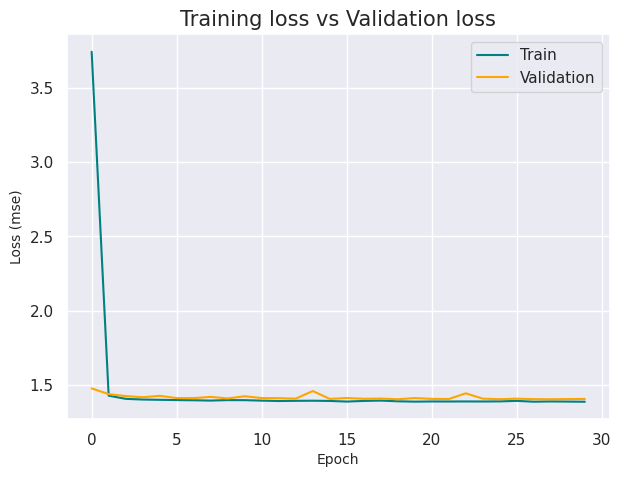

In [151]:
model2 = nn_model(input_size = 47).to(device)
optimizer = optim.Adam(model2.parameters(), lr = 0.001)
results = train_model(model2, 30, optimizer, train_loader3, valid_loader3)

In [153]:
X_train_scaled.shape

(29842, 39)

In [154]:
train_dataset4 = MyDataset(X_train_scaled, y_train)
test_dataset4 = MyDataset(X_test_scaled, y_test)
valid_dataset4 = MyDataset(X_valid_scaled, y_valid)

In [155]:
train_loader4 = DataLoader(train_dataset4, batch_size = 64, shuffle = True)
test_loader4 = DataLoader(test_dataset4, batch_size = 64, shuffle = False)
valid_loader4 = DataLoader(valid_dataset4, batch_size = 64, shuffle = False)

Train Loss: 1.390 | Validation Loss: 1.406: 100%|██████████| 30/30 [00:32<00:00,  1.10s/it]


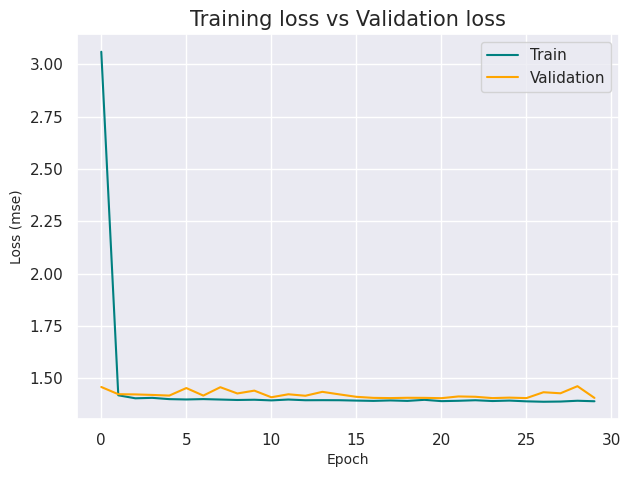

In [156]:
model3 = nn_model(input_size = 39).to(device)
optimizer = optim.Adam(model3.parameters(), lr = 0.001)
results = train_model(model3, 30, optimizer, train_loader4, valid_loader4)